<h1 align="center">Проект "Прогнозирование невыполнения долговых обязательств по текущему кредиту"</h1>

### Постановка задачи

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### Описание датасета
<ul>
    <li><b>Home Ownership</b> - домовладение</li>
    <li><b>Annual Income</b> - годовой доход</li>
    <li><b>Years in current job</b> - количество лет на текущем месте работы</li>
    <li><b>Tax Liens</b> - налоговые обременения</li>
    <li><b>Number of Open Accounts</b> - количество открытых счетов</li>
    <li><b>Years of Credit History</b> - количество лет кредитной истории</li>
    <li><b>Maximum Open Credit</b> - наибольший открытый кредит</li>
    <li><b>Number of Credit Problems</b> - количество проблем с кредитом</li>
    <li><b>Months since last delinquent</b> - количество месяцев с последней просрочки платежа</li>
    <li><b>Bankruptcies</b> - банкротства</li>
    <li><b>Purpose</b> - цель кредита</li>
    <li><b>Term</b> - срок кредита</li>
    <li><b>Current Loan Amount</b> - текущая сумма кредита</li>
    <li><b>Current Credit Balance</b> - текущий кредитный баланс</li>
    <li><b>Monthly Debt</b> - ежемесячный долг</li>
    <li><b>Credit Score</b> - кредитный рейтинг</li>
    <li><b>Credit Default</b> - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)</li>
</ul>

### Целевая переменная

<b>Credit Default</b> - факт невыполнения кредитных обязательств

### Требования к метрике качества

<ul>
    <li>F1-score > 0.5</li>
    <li>Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)</li>
</ul>

## Этап 1. Сбор (загрузка) данных

### 1.1 Подключение библиотек

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro, mannwhitneyu

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

from math import floor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
matplotlib.rcParams.update({"font.size": 14})

### 1.2 Загрузка данных

In [3]:
TRAIN_DATASET_PATH = "course_project_train.csv"
TEST_DATASET_PATH = "course_project_test.csv"

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [6]:
print(f"Размерность тренировочных данных: {train_df.shape}\nразмерность тестовых данных :{test_df.shape}")

Размерность тренировочных данных: (7500, 17)
размерность тестовых данных :(2500, 16)


## Этап 2. Разведочный (первичный) анализ данных

### 2.1 Типы переменных

#### Обзор типов переменных

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

<i>В приведении типов переменных данного датасета нет необходимости</i>

### 2.2 Обзор независимых переменных

In [8]:
target = "Credit Default"
numeric_features = [num_colname for num_colname in train_df.select_dtypes(exclude="object").columns]
numeric_features.remove(target)
categorial_features = [cat_colname for cat_colname in train_df.select_dtypes(include="object").columns]

In [9]:
print(f"Количество количественных переменных - {len(numeric_features)}, номинативных - {len(categorial_features)}")

Количество количественных переменных - 12, номинативных - 4


#### Обзор количественных признаков

<i>Вывод описательных статистик</i>

In [10]:
train_df[numeric_features].describe() 

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


#### Обзор качественных признаков

<i>Визуализация распределений классов категориальных переменных</i>

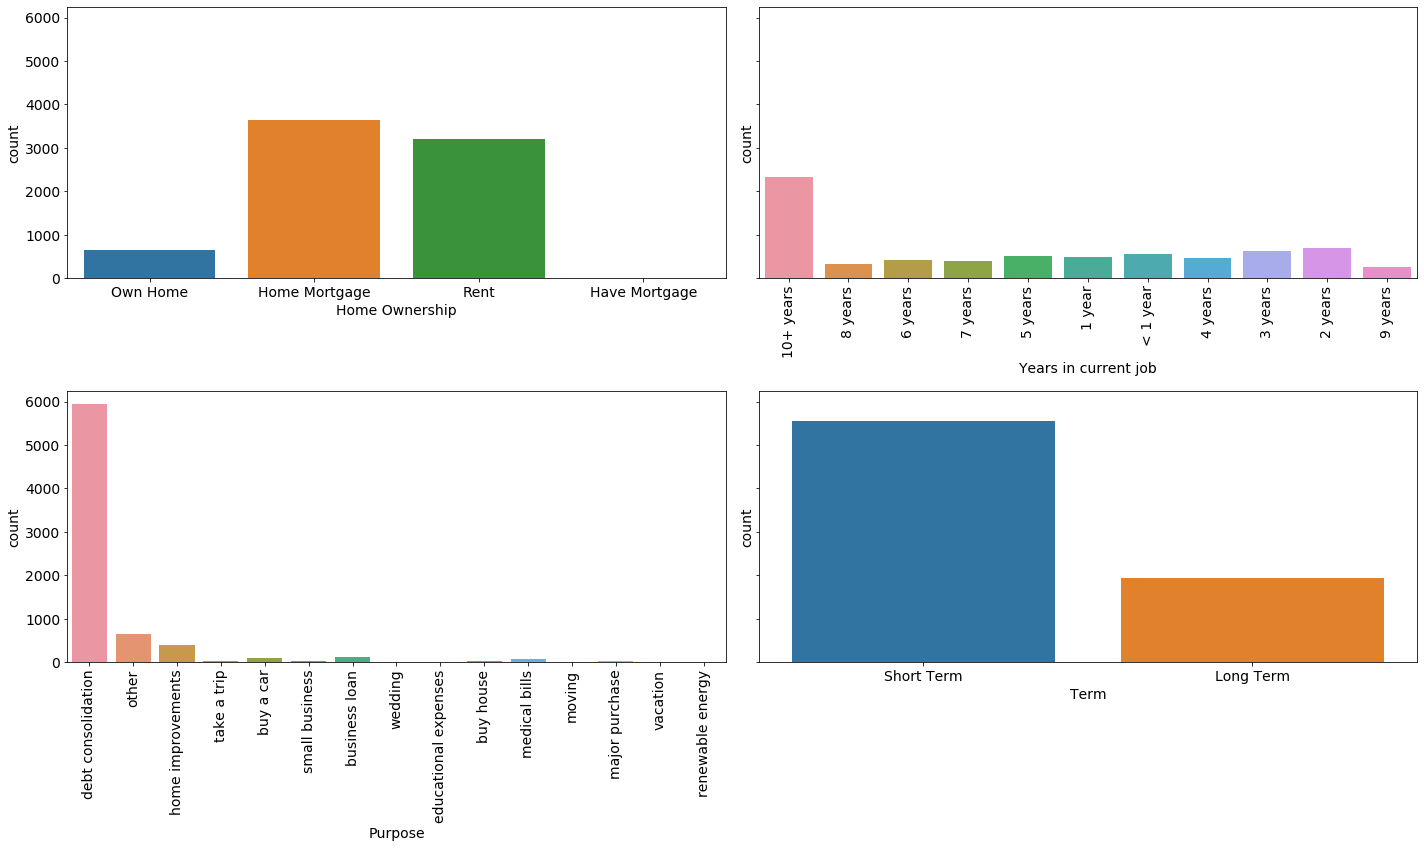

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(20, 12))

for n in range(len(categorial_features)):
    i, j = floor(n / 2), n % 2
    axes[i][j].set(xlabel = categorial_features[n])
    bar = sns.countplot(x=train_df[categorial_features[n]],  ax=axes[i, j])
    if len(train_df[categorial_features[n]].unique()) > 6:
        bar.set_xticklabels(bar.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### 2.3 Анализ целевого атрибута

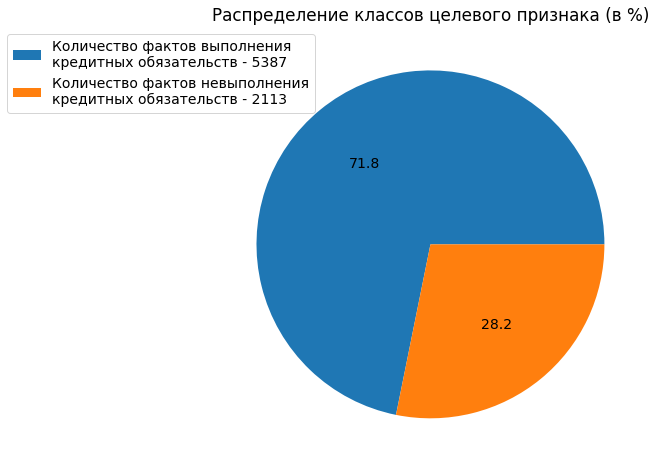

In [12]:
plt.figure(figsize=(8, 8))
plt.pie(train_df[target].value_counts(), autopct="%.1f")
plt.legend([f"Количество фактов выполнения\nкредитных обязательств - {train_df[target].value_counts()[0]}", 
            f"Количество фактов невыполнения\nкредитных обязательств - {train_df[target].value_counts()[1]}"],
                bbox_to_anchor = (0, 0.75, 0.25, 0.25))
plt.title("Распределение классов целевого признака (в %)")
plt.show()

<i>Визуализация распределения признака Credit Default отображает явный дисбаланс классов</i>

## Этап 3. Предварительная обработка данных

### 3.1 Обработка грязных данных (дупликатов, пропущенных значений, выбросов (outliers))
<ul>
    <li>Удаление строк с грязными данными</li>
    <li>Заполнение средними статистиками (среднее, медиана, мода)</li>
    <li>Бездействие</li>
    <li>Генерация новых фичей</li>
</ul>

#### Обработка дупликатов

In [13]:
print(f"Количество дупликатов по всем атрибутам: {train_df[train_df.duplicated(keep=False)].shape[0]}")

Количество дупликатов по всем атрибутам: 0


#### Обработка пропусков

In [14]:
for column_name in train_df.columns:
    nulls_fraction = train_df[column_name].isna().sum()/train_df[column_name].shape[0]
    print(f"{column_name} - {train_df[column_name].isna().sum()} ({round(nulls_fraction * 100)}%)")

Home Ownership - 0 (0.0%)
Annual Income - 1557 (21.0%)
Years in current job - 371 (5.0%)
Tax Liens - 0 (0.0%)
Number of Open Accounts - 0 (0.0%)
Years of Credit History - 0 (0.0%)
Maximum Open Credit - 0 (0.0%)
Number of Credit Problems - 0 (0.0%)
Months since last delinquent - 4081 (54.0%)
Bankruptcies - 14 (0.0%)
Purpose - 0 (0.0%)
Term - 0 (0.0%)
Current Loan Amount - 0 (0.0%)
Current Credit Balance - 0 (0.0%)
Monthly Debt - 0 (0.0%)
Credit Score - 1557 (21.0%)
Credit Default - 0 (0.0%)


<i>Следует заметить, что по признаку Months since last delinquent больше 50% значений - пропуски, он не является информативным.</i><br/><i>Отбросим данный признак</i>

In [15]:
train_df = train_df.drop(["Months since last delinquent"], axis=1)
numeric_features.remove("Months since last delinquent")

<i>Заменим пропуски количественных переменных медианой, качественных - модой</i>

In [16]:
for column_name in train_df.columns:
    if column_name in numeric_features:
        train_df[column_name] = train_df[column_name].fillna(train_df[column_name].median())
    elif column_name in categorial_features:
        train_df[column_name] = train_df[column_name].fillna(train_df[column_name].mode()[0])

In [17]:
print(f"Количество пропусков по всем атрибутам: {train_df.isna().sum().sum()}")

Количество пропусков по всем атрибутам: 0


#### Обработка шумов

<i>Визуализация вариативности переменных и исследование аномалий</i>

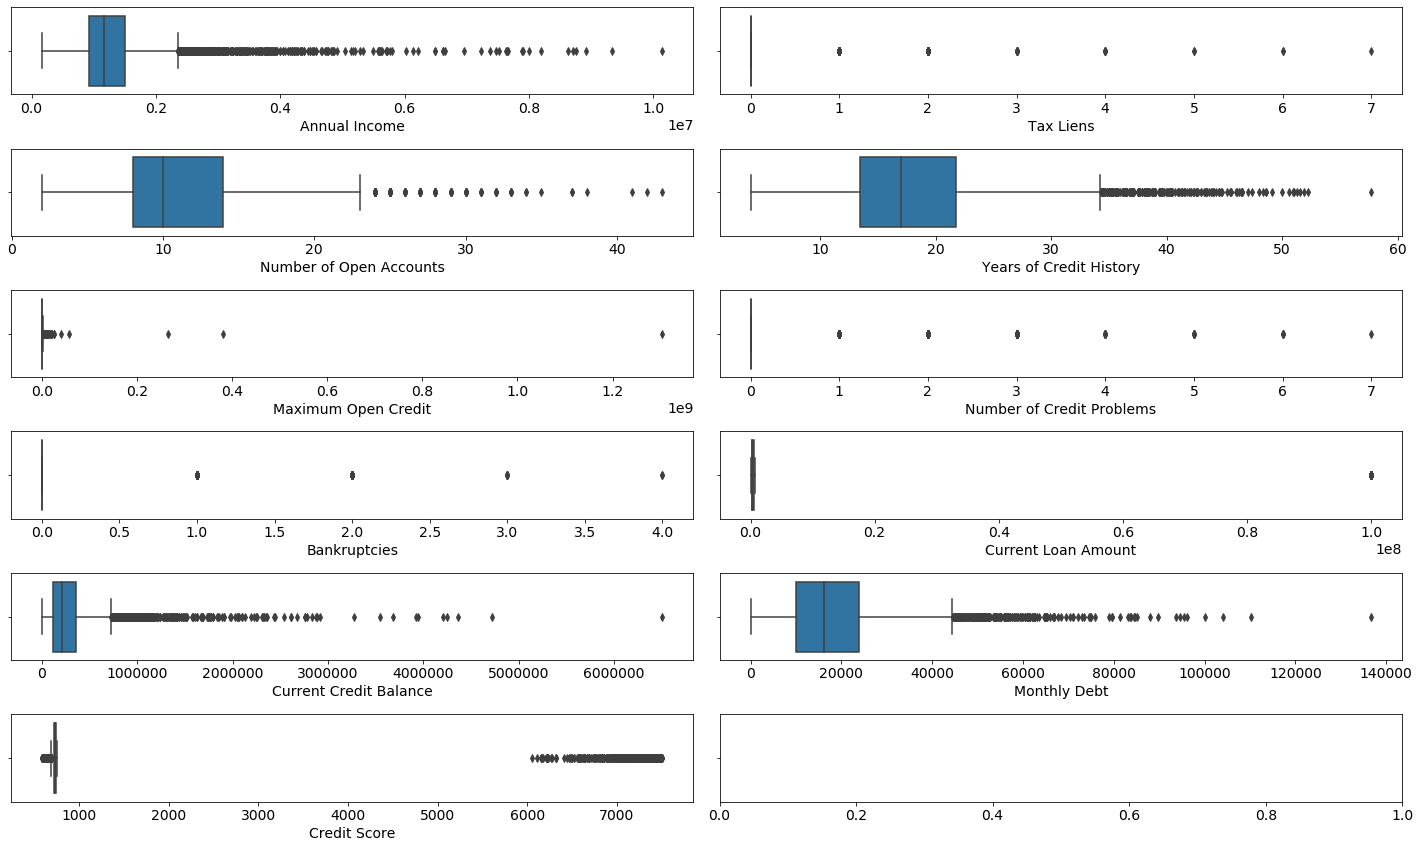

In [18]:
fig, axes = plt.subplots(nrows=6, ncols=2, sharey=True, figsize=(20, 12))

for n in range(len(numeric_features)):
    i, j = floor(n / 2), n % 2
    axes[i][j].set(xlabel = numeric_features[n])
    sns.boxplot(x=train_df[numeric_features[n]], ax=axes[i, j])
plt.tight_layout()
plt.show()

##### Annual Income, Number of Open Accounts, Years of Credit History, Maximum Open Credit, Current Credit Balance, Monthly Debt

In [19]:
for column_name in ["Annual Income", "Number of Open Accounts", "Years of Credit History", "Maximum Open Credit", 
                    "Current Credit Balance", "Monthly Debt"]:
    right_quantile = train_df[column_name].quantile(q=0.95)
    train_df.loc[train_df[column_name] > right_quantile, column_name] = train_df[column_name].median()

##### Credit Score

<i>Согласно наиболее популярным моделям кредитного скоринга, значения Credit Score &isin; [300; 850]</i>

In [20]:
train_df.loc[train_df["Credit Score"] < 300, "Credit Score"].value_counts()

Series([], Name: Credit Score, dtype: int64)

In [21]:
train_df.loc[train_df["Credit Score"] > 850, "Credit Score"].value_counts()

7400.0    15
7300.0    13
7330.0    13
7170.0    12
7370.0    12
          ..
6830.0     1
6910.0     1
6450.0     1
6610.0     1
6170.0     1
Name: Credit Score, Length: 110, dtype: int64

<i>Вынесем значения Credit Score &notin; [300; 850] в отдельную переменную</i>

In [22]:
train_df["Credit Score Outlier"] = 0
train_df.loc[(train_df["Credit Score"] > 850) | (train_df["Credit Score"] < 300), "Credit Score Outlier"] = 1

<i>Обработаем пропуски базового признака</i>

In [23]:
train_df.loc[(train_df["Credit Score"] > 850) | (train_df["Credit Score"] < 300), "Credit Score"] =\
train_df.loc[(train_df["Credit Score"] <= 850) & (train_df["Credit Score"] >= 300), "Credit Score"].mean()

In [24]:
train_df.loc[(train_df["Credit Score"] > 850) | (train_df["Credit Score"] < 300), "Credit Score"].value_counts()

Series([], Name: Credit Score, dtype: int64)

##### Current Loan Amount

In [25]:
train_df["Current Loan Amount"].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

<i>Значение 99999999.0 довольно часто встречается для выброса, выделим его в отдельных признак<i/>

In [26]:
train_df.loc[train_df["Current Loan Amount"] < 99999999.0, "Current Loan Amount Outlier"] = 0 

In [27]:
train_df.loc[train_df["Current Loan Amount"] == 99999999.0, "Current Loan Amount Outlier"] = 1

<i>Обработаем значение 99999999.0 в базовом признаке</i>

In [28]:
train_df.loc[train_df["Current Loan Amount"] == 99999999.0, "Current Loan Amount"] = train_df["Current Loan Amount"].median()

In [29]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Credit Score Outlier,Current Loan Amount Outlier
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,1.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,0.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,17.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,1.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0.0


### 3.2 Кодирование переменных  & Генерация новых фичей

#### Бинарное кодирование (Feature Binarization)

##### Term

In [30]:
binary_values = {"Short Term": 0, "Long Term": 1}
train_df["Term"] = train_df["Term"].replace(binary_values)
train_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Credit Score Outlier,Current Loan Amount Outlier
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,other,0,129360.0,73492.0,1900.0,697.00000,0,0,0.0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,0.0,debt consolidation,1,444048.0,456399.0,12783.0,722.96338,1,1,0.0
7497,Rent,1878910.0,6 years,0.0,12.0,17.0,478159.0,0.0,0.0,buy a car,0,309573.0,477812.0,12479.0,748.00000,0,0,1.0
7498,Home Mortgage,1168386.0,10+ years,0.0,10.0,26.5,1141250.0,0.0,0.0,debt consolidation,0,615274.0,476064.0,37118.0,731.00000,0,0,0.0
7499,Rent,1168386.0,4 years,0.0,8.0,9.4,480832.0,0.0,0.0,debt consolidation,0,26928.0,288192.0,9061.0,731.00000,0,0,0.0


#### One-Hot Encoding

##### Home Ownership

In [31]:
train_df = pd.get_dummies(train_df, columns=["Home Ownership"])
train_df.columns.to_list()

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Credit Score Outlier',
 'Current Loan Amount Outlier',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent']

#### Целевое кодирование (Target-based Encoding)

##### Purpose By Target Credit Default Probability

In [32]:
purpose_by_target_credit_default = train_df.groupby(["Purpose", "Credit Default"])[["Credit Default"]].agg("count").\
rename(columns={"Credit Default": "Purpose By Target Credit Default Quantity"}).reset_index()

In [33]:
purpose_by_target_credit_default = purpose_by_target_credit_default.\
loc[purpose_by_target_credit_default["Credit Default"] == 1, :]
purpose_by_target_credit_default.head()

,Purpose,Credit Default,Purpose By Target Credit Default Quantity
1,business loan,1,55
3,buy a car,1,24
5,buy house,1,9
7,debt consolidation,1,1654
9,educational expenses,1,1


In [34]:
purpose_object_quantity = train_df.groupby(["Purpose"])[["Purpose"]].agg("count").\
rename(columns={"Purpose": "Purpose Quantity"}).reset_index()
purpose_object_quantity.head()

,Purpose,Purpose Quantity
0,business loan,129
1,buy a car,96
2,buy house,34
3,debt consolidation,5944
4,educational expenses,10


In [35]:
purpose_by_target_credit_default = purpose_by_target_credit_default.merge(purpose_object_quantity, on="Purpose", how="left")
purpose_by_target_credit_default.head()

,Purpose,Credit Default,Purpose By Target Credit Default Quantity,Purpose Quantity
0,business loan,1,55,129
1,buy a car,1,24,96
2,buy house,1,9,34
3,debt consolidation,1,1654,5944
4,educational expenses,1,1,10


In [36]:
purpose_by_target_credit_default["Purpose By Target Credit Default Probability"] =\
round(purpose_by_target_credit_default["Purpose By Target Credit Default Quantity"] / 
      purpose_by_target_credit_default["Purpose Quantity"], 2)
purpose_by_target_credit_default.head()

,Purpose,Credit Default,Purpose By Target Credit Default Quantity,Purpose Quantity,Purpose By Target Credit Default Probability
0,business loan,1,55,129,0.43
1,buy a car,1,24,96,0.25
2,buy house,1,9,34,0.26
3,debt consolidation,1,1654,5944,0.28
4,educational expenses,1,1,10,0.10


In [37]:
purpose_by_target_credit_default.drop(columns=["Credit Default", "Purpose By Target Credit Default Quantity",
                                               "Purpose Quantity"], axis=1, inplace=True)
train_df = train_df.merge(purpose_by_target_credit_default, on=["Purpose"], how="left")
train_df.tail()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,...,Monthly Debt,Credit Score,Credit Default,Credit Score Outlier,Current Loan Amount Outlier,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose By Target Credit Default Probability
7495,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,other,0,...,1900.0,697.00000,0,0,0.0,0,0,0,1,0.30
7496,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,0.0,debt consolidation,1,...,12783.0,722.96338,1,1,0.0,0,1,0,0,0.28
7497,1878910.0,6 years,0.0,12.0,17.0,478159.0,0.0,0.0,buy a car,0,...,12479.0,748.00000,0,0,1.0,0,0,0,1,0.25
7498,1168386.0,10+ years,0.0,10.0,26.5,1141250.0,0.0,0.0,debt consolidation,0,...,37118.0,731.00000,0,0,0.0,0,1,0,0,0.28
7499,1168386.0,4 years,0.0,8.0,9.4,480832.0,0.0,0.0,debt consolidation,0,...,9061.0,731.00000,0,0,0.0,0,0,0,1,0.28


<i>Функция для предобработки данных</i>

In [38]:
def data_preprocess(new_df, basic_df):
    # Months since last delinquent
    new_df = new_df.drop(["Months since last delinquent"], axis=1)
    
    # Пропуски
    for column_name in new_df.columns:
        if column_name in numeric_features:
            new_df[column_name] = new_df[column_name].fillna(basic_df[column_name].median())
        elif column_name in categorial_features:
            new_df[column_name] = new_df[column_name].fillna(basic_df[column_name].mode()[0])
    
    # Annual Income, Number of Open Accounts, Years of Credit History, Maximum Open Credit, 
    # Current Credit Balance, Monthly Debt
    for column_name in ["Annual Income", "Number of Open Accounts", "Years of Credit History", "Maximum Open Credit", 
                    "Current Credit Balance", "Monthly Debt"]:
        right_quantile = basic_df[column_name].quantile(q=0.95)
        new_df.loc[new_df[column_name] > right_quantile, column_name] = basic_df[column_name].median()
        
    # Credit Score
    new_df["Credit Score Outlier"] = 0
    new_df.loc[(new_df["Credit Score"] > 850) | (new_df["Credit Score"] < 300), "Credit Score Outlier"] = 1
        
    new_df.loc[(new_df["Credit Score"] > 850) | (new_df["Credit Score"] < 300), "Credit Score"] =\
    basic_df.loc[(basic_df["Credit Score"] <= 850) & (basic_df["Credit Score"] >= 300), "Credit Score"].mean()
    
    # Current Loan Amount
    new_df.loc[new_df["Current Loan Amount"] < 99999999.0, "Current Loan Amount Outlier"] = 0 
    new_df.loc[new_df["Current Loan Amount"] == 99999999.0, "Current Loan Amount Outlier"] = 1
    
    new_df.loc[new_df["Current Loan Amount"] == 99999999.0, "Current Loan Amount"] = basic_df["Current Loan Amount"].median()    
    
    
    return new_df

<i></i>

#### Генерация новых признаков

##### Tax Liens, Number of Credit Problems, Bankruptcies

<i>Предположительно, переменные Tax Liens, Number of Credit Problems, Bankruptcies описывают одну характеристику - проблемы клиента<br/>Изучим взаимосвязь этих переменных</i>

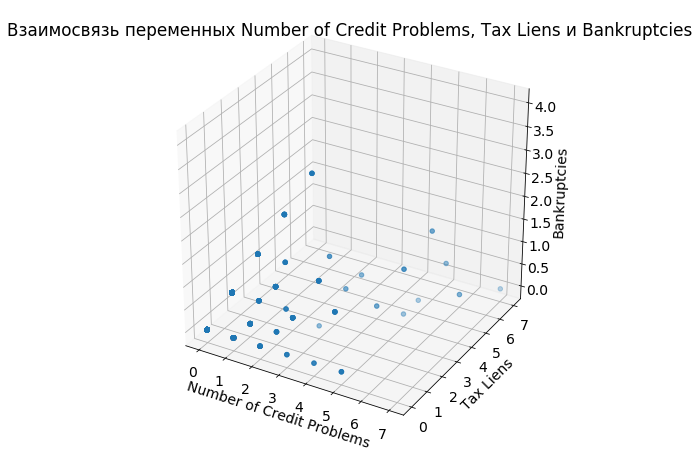

In [39]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection = "3d")

x = train_df["Number of Credit Problems"]
y = train_df["Tax Liens"]
z = train_df["Bankruptcies"]

axes.scatter(x, y, z)
axes.set_xlabel("Number of Credit Problems")
axes.set_ylabel("Tax Liens")
axes.set_zlabel("Bankruptcies")
plt.title("Взаимосвязь переменных Number of Credit Problems, Tax Liens и Bankruptcies")

plt.show()

In [40]:
train_df[["Tax Liens", "Number of Credit Problems", "Bankruptcies"]].corr()

,Tax Liens,Number of Credit Problems,Bankruptcies
Tax Liens,1.000000,0.595339,0.057423
Number of Credit Problems,0.595339,1.000000,0.730808
Bankruptcies,0.057423,0.730808,1.000000


<i>Диаграмма рассеивания и таблица с корреляциями отображают достаточно сильную взаимосвязь переменных Tax Liens и Number of Credit Problems, Bankruptcies и Number of Credit Problems<br/>Выразим их через один признак - Total Problems</i>

In [41]:
train_df["Total Problems"] = train_df["Tax Liens"] + train_df["Number of Credit Problems"] + train_df["Bankruptcies"]
train_df["Total Problems"].value_counts()

0.0     6469
2.0      805
1.0       88
4.0       67
6.0       26
3.0       22
5.0        7
8.0        5
12.0       4
10.0       3
7.0        2
14.0       1
9.0        1
Name: Total Problems, dtype: int64

<i>Большинство объектов по данному признаку имеют значение 0, поэтому будем рассматривать его как категориальный признак Without Problems с 2 классами:<i>
    <ul>
        <li><i>0 - наличие проблем</i></li>
        <li><i>1 - отсутствие проблем</i></li>
    </ul>

In [42]:
train_df.loc[train_df["Total Problems"] > 0, "Without Problems"] = 0
train_df.loc[train_df["Total Problems"] == 0, "Without Problems"] = 1

In [43]:
train_df.drop(["Total Problems"], axis=1, inplace=True)
train_df["Without Problems"].value_counts()

1.0    6469
0.0    1031
Name: Without Problems, dtype: int64

##### Monthly Balance After Payment

In [44]:
train_df["Monthly Balance After Payment"] = round((train_df["Annual Income"]/12) - train_df["Monthly Debt"], 2)

<i>Функция для кодирования данных и генерации новых признаков</i>

In [45]:
def feature_generate(new_df, basic_features, basic_target):
    basic_df = basic_features.copy()
    basic_df["Credit Default"] = basic_target.values
    
    # Бинарное кодирование (Feature Binarization)
    binary_values = {"Short Term": 0, "Long Term": 1}
    new_df["Term"] = new_df["Term"].replace(binary_values)
    
    # One-Hot Encoding
    new_df = pd.get_dummies(new_df, columns=["Home Ownership"])
    
    # Without Problems
    new_df["Total Problems"] = new_df["Tax Liens"] + new_df["Number of Credit Problems"] + new_df["Bankruptcies"]
    new_df.loc[new_df["Total Problems"] > 0, "Without Problems"] = 0
    new_df.loc[new_df["Total Problems"] == 0, "Without Problems"] = 1
    new_df.drop(["Total Problems"], axis=1, inplace=True)

    # Monthly Balance After Payment
    new_df["Monthly Balance After Payment"] = round((new_df["Annual Income"]/12) - new_df["Monthly Debt"], 2)
    
    # Purpose By Target Credit Default Probability
    
    purpose_by_target_credit_default = basic_df.groupby(["Purpose", "Credit Default"])[["Credit Default"]].agg("count").\
    rename(columns={"Credit Default": "Purpose By Target Credit Default Quantity"}).reset_index()
    
    purpose_by_target_credit_default = purpose_by_target_credit_default.\
    loc[purpose_by_target_credit_default["Credit Default"] == 1, :]
    
    purpose_object_quantity = basic_df.groupby(["Purpose"])[["Purpose"]].agg("count").\
    rename(columns={"Purpose": "Purpose Quantity"}).reset_index()
    
    purpose_by_target_credit_default = purpose_by_target_credit_default.merge(purpose_object_quantity, on="Purpose", how="left")
    
    purpose_by_target_credit_default["Purpose By Target Credit Default Probability"] =\
    round(purpose_by_target_credit_default["Purpose By Target Credit Default Quantity"] / 
      purpose_by_target_credit_default["Purpose Quantity"], 2)
    
    purpose_by_target_credit_default.drop(columns=["Credit Default", "Purpose By Target Credit Default Quantity",
                                               "Purpose Quantity"], axis=1, inplace=True)
    new_df = new_df.merge(purpose_by_target_credit_default, on=["Purpose"], how="left")
    
    
    return new_df

## Этап 4. Отбор признаков

### 4.1 Проверка статистических гипотез

<i>Изучим зависимость между Monthly Balance After Payment и целевым атрибутом</i>

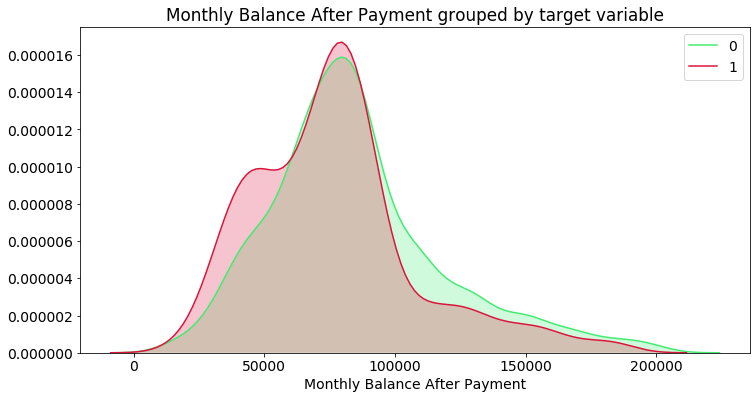

In [46]:
monthly_balance_after_payment_with_target_s = train_df[["Monthly Balance After Payment", target]].sample(1500)
monthly_balance_after_payment_s = monthly_balance_after_payment_with_target_s["Monthly Balance After Payment"]
monthly_balance_after_payment_target_0 = monthly_balance_after_payment_s[monthly_balance_after_payment_with_target_s[target] == 0]
monthly_balance_after_payment_target_1 = monthly_balance_after_payment_s[monthly_balance_after_payment_with_target_s[target] == 1]

plt.figure(figsize=(12, 6))

sns.kdeplot(monthly_balance_after_payment_target_0, shade=True, label="0", color="#42EC71")
sns.kdeplot(monthly_balance_after_payment_target_1, shade=True, label="1", color="#DC143C")

plt.xlabel("Monthly Balance After Payment")
plt.title("Monthly Balance After Payment grouped by target variable")
plt.show()

<i>График "Monthly Balance After Payment grouped by target variable" отображает некую зависимость распределения переменной Monthly balance after payment от принадлежности к разным классам Credit Default</i>

<i>Построим гипотезы:
    <ul>
        <li>Нулевая гипотеза: средние статистики в двух независимых выборках равны</li>
        <li>Альтернативная гипотеза: средние статистики в двух независимых выборках различны</li>
    </ul>
</i>

<i>Проверим распределение Monthly Balance After Payment на нормальность</i>

In [47]:
shapiro(monthly_balance_after_payment_s)[1] < 0.05

True

<i>p-value<0.05, поэтому отклоняем нулевую гипотезу о нормальности распределения</i>

<i>Ввиду того, что распределение Monthly Balance After Payment не подчиняется нормальному закону, для проверки статистической гипотезы будет использован непараметрический критерий Манна-Уитни</i>

In [48]:
U, p = mannwhitneyu(monthly_balance_after_payment_target_0, monthly_balance_after_payment_target_1)
p

1.563438841319568e-06

<i> На основании значения p-value << 0.05 отвергаем нулевую гипотезу о равенстве средних двух распределений признака Monthly Balance After Payment, полученных в результате разбиения объектов по классам целевого атрибута.</i>

<i>Предположение о существующей статистической значимости между изученными признаками оказалось верным</i>

### 4.2 Анализ взаимосвязей переменных

#### Корреляционная матрица

In [49]:
train_df.insert(len(train_df.columns.to_list()), "Credit Default Temporary", train_df["Credit Default"])
train_df.drop(["Credit Default"], axis=1, inplace=True)
train_df = train_df.rename(columns={"Credit Default Temporary": "Credit Default"})

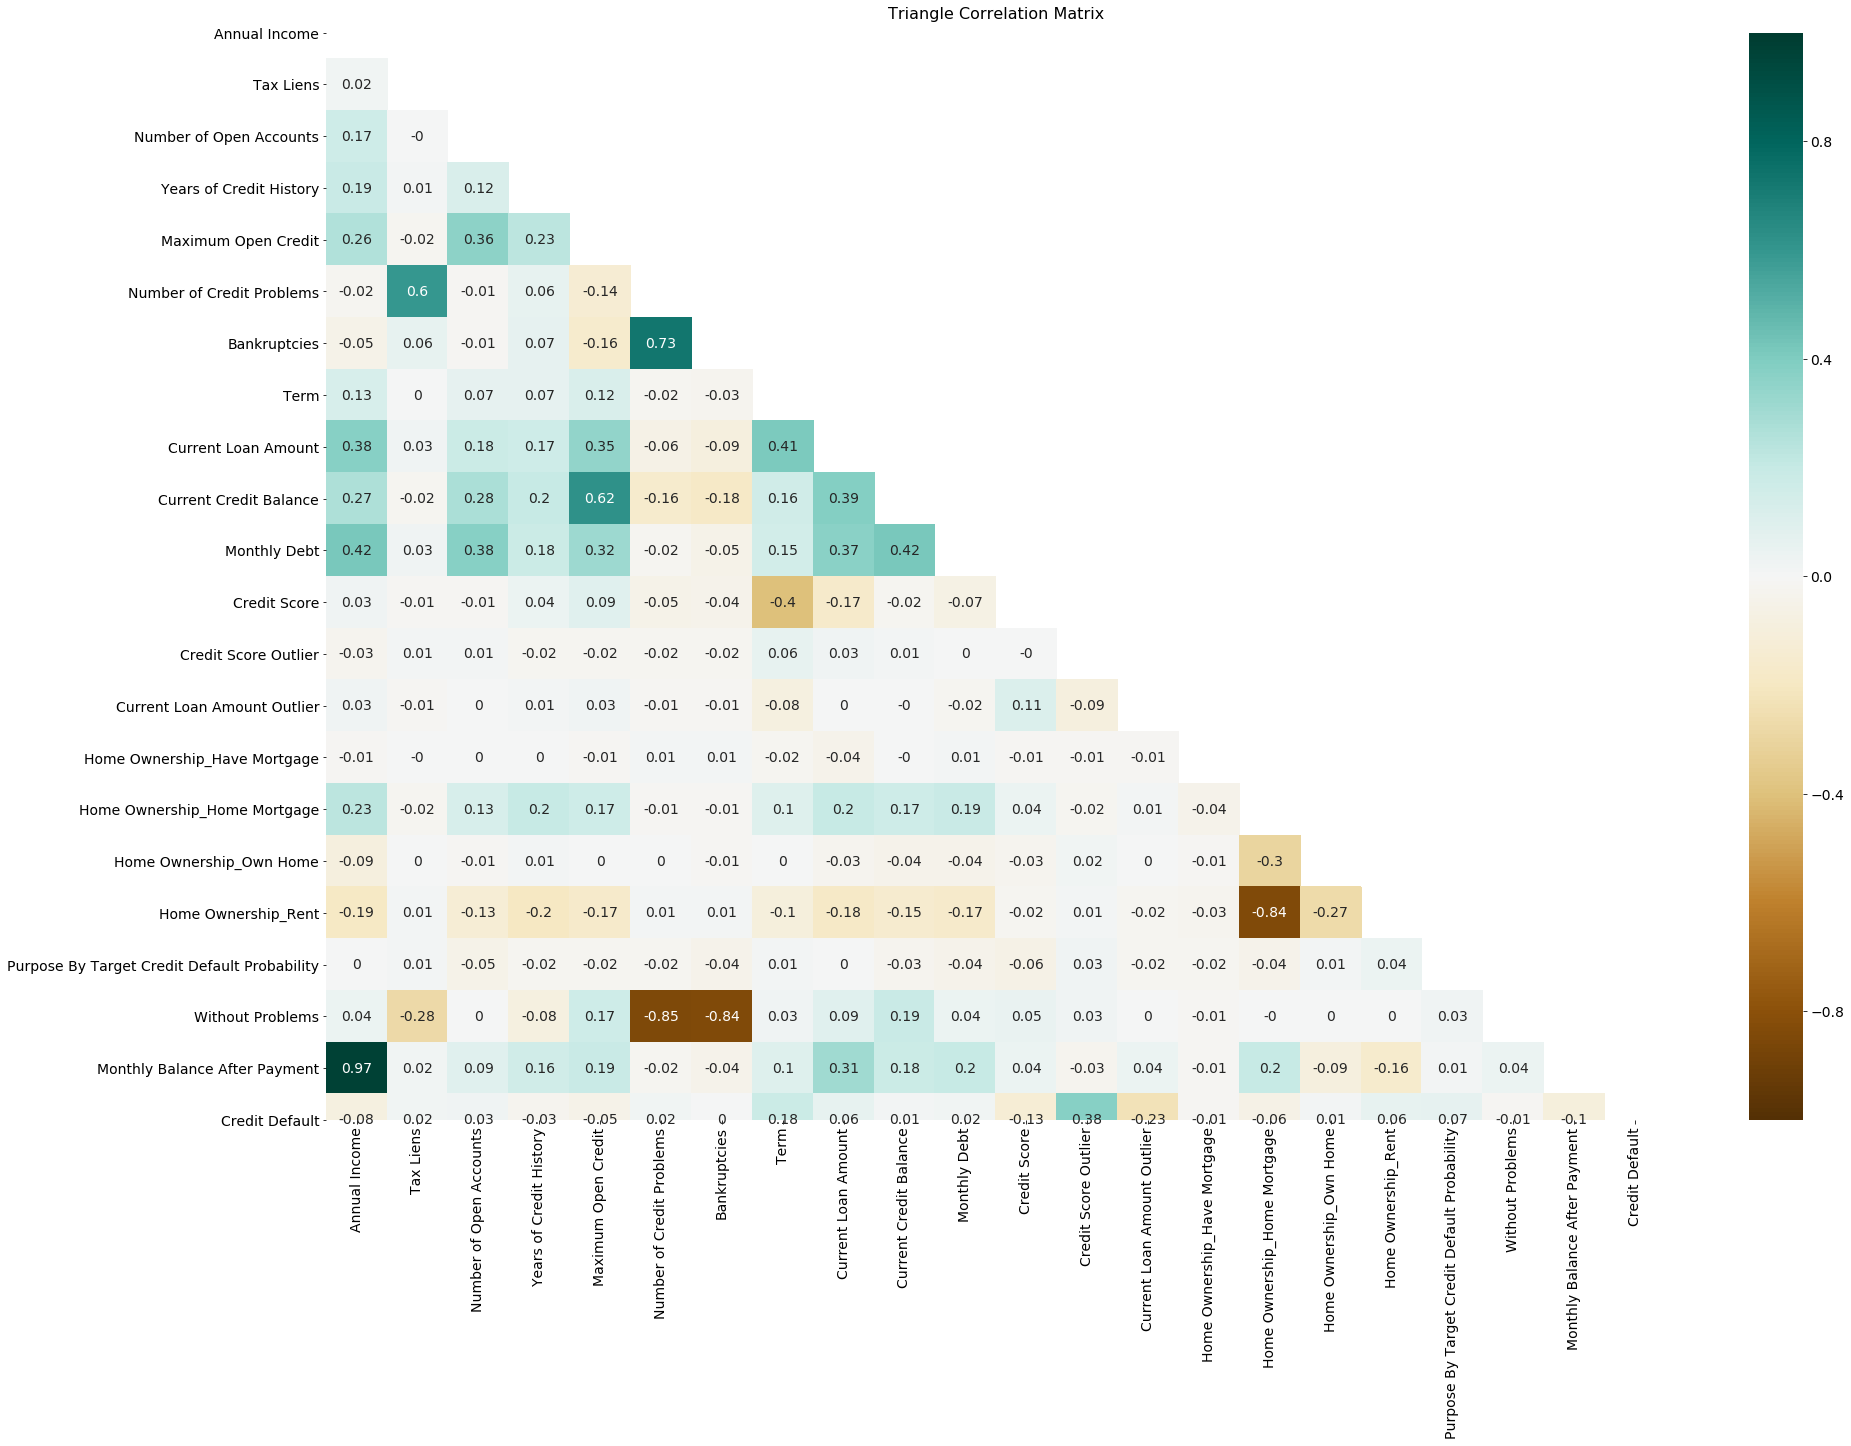

In [50]:
plt.figure(figsize=(30, 20))
mask = np.triu(np.ones_like(train_df.corr().round(2), dtype=np.bool))
heatmap = sns.heatmap(train_df.corr().round(2), mask=mask, vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Triangle Correlation Matrix", fontdict={"fontsize":16}, pad=14);

#### Корреляция независимых признаков с целевым атрибутом

In [51]:
target_corr = train_df.corr()[[target]]
target_corr = target_corr.reset_index()
target_corr.columns = ["Feature", "Credit Default"]
target_corr = target_corr.loc[target_corr["Feature"] != "Credit Default", :]
target_corr.sort_values(by=["Credit Default"], axis=0, ascending=False, inplace=False)

,Feature,Credit Default
12,Credit Score Outlier,0.378987
7,Term,0.181487
18,Purpose By Target Credit Default Probability,0.065695
8,Current Loan Amount,0.064181
17,Home Ownership_Rent,0.060114
2,Number of Open Accounts,0.033703
1,Tax Liens,0.024368
5,Number of Credit Problems,0.020088
10,Monthly Debt,0.017559
16,Home Ownership_Own Home,0.010260


#### Отбор признаков

In [52]:
selected_features = ["Monthly Balance After Payment", "Number of Open Accounts", "Years of Credit History", 
                     "Maximum Open Credit", "Current Loan Amount", "Current Loan Amount Outlier", "Term",
                     "Credit Score", "Credit Score Outlier", "Home Ownership_Home Mortgage",
                      "Purpose By Target Credit Default Probability"]

train_df = train_df[selected_features + [target]]

## Этап 5. Построение модели

### 5.1 Разбиение данных на train и test выборки

In [53]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

x = train_df.drop(columns=["Credit Default"])
y = train_df[["Credit Default"]]

In [54]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, shuffle=True, random_state = 42)

In [55]:
x_train = data_preprocess(x_train, x_train)
x_valid = data_preprocess(x_valid, x_train)
test_df = data_preprocess(test_df, x_train)

x_train.shape, x_valid.shape, test_df.shape

((6000, 17), (1500, 17), (2500, 17))

In [56]:
x_train = feature_generate(x_train, x_train, y_train)
x_valid = feature_generate(x_valid, x_train, y_train)
test_df = feature_generate(test_df, x_train, y_train)

x_train = x_train[selected_features]
x_valid = x_valid[selected_features]
test_df = test_df[selected_features]

x_train.shape, x_valid.shape, test_df.shape

((6000, 11), (1500, 11), (2500, 11))

In [57]:
x_train.isna().sum().sum(), x_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 5.2 Балансировка классов целевой переменной

In [58]:
sm = SMOTE(random_state=0, k_neighbors=4)
x_train, y_train = sm.fit_resample(x_train, y_train)

### 5.3 Обучение модели

<i>Функция для оценки качества моделей</i>

In [59]:
def pred_model(model):
    model.fit(x_train, y_train)
    y_valid_pred = model.predict(x_valid)

    print(model, ": ", f1_score(y_valid, y_valid_pred))

<i>Построение различных моделей машинного обучения и сравнение их метрик качества (F1-score)</i>

In [60]:
pred_model(LogisticRegression(penalty="l2"))

LogisticRegression() :  0.43674456083803387


In [61]:
pred_model(KNeighborsClassifier())

KNeighborsClassifier() :  0.3801498127340824


In [62]:
pred_model(RandomForestClassifier(max_depth=14, n_estimators=1000, random_state=42))

RandomForestClassifier(max_depth=14, n_estimators=1000, random_state=42) :  0.5185972369819342


In [63]:
final_model = RandomForestClassifier(max_depth=14, n_estimators=1000, random_state=42)
final_model.fit(x_train, y_train)
y_train_pred = final_model.predict(x_train)
y_valid_pred = final_model.predict(x_valid)

### 5.5 Оценка качества модели

In [64]:
print("TRAIN\n\n" + classification_report(y_train, y_train_pred))

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4328
           1       0.91      0.96      0.94      4328

    accuracy                           0.93      8656
   macro avg       0.94      0.93      0.93      8656
weighted avg       0.94      0.93      0.93      8656



In [65]:
print("TEST\n\n"+ classification_report(y_valid, y_valid_pred))

TEST

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1059
           1       0.49      0.55      0.52       441

    accuracy                           0.70      1500
   macro avg       0.65      0.66      0.65      1500
weighted avg       0.71      0.70      0.70      1500



### 5.6 Важность признаков

In [66]:
feature_importances = pd.DataFrame(zip(x_train.columns, final_model.feature_importances_), 
                                   columns=["feature_name", "importance"])

feature_importances.sort_values(by="importance", ascending=False)

,feature_name,importance
7,Credit Score,0.198516
4,Current Loan Amount,0.122803
0,Monthly Balance After Payment,0.108219
5,Current Loan Amount Outlier,0.098421
1,Number of Open Accounts,0.098266
3,Maximum Open Credit,0.096453
2,Years of Credit History,0.084157
10,Purpose By Target Credit Default Probability,0.068549
9,Home Ownership_Home Mortgage,0.057153
8,Credit Score Outlier,0.053963


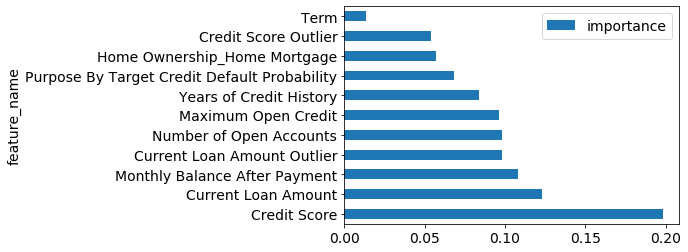

In [67]:
feature_importances = feature_importances.sort_values(by="importance", ascending=False)
feature_importances.set_index("feature_name", inplace=True)
feature_importances.plot(kind="barh")

### 5.7 Прогноз таргета

In [68]:
target_predictions = final_model.predict(test_df)
target_predictions[:15]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [69]:
test_df["Credit Default"] = target_predictions
test_df[["Credit Default"]].head(10)

,Credit Default
0,0
1,1
2,1
3,0
4,0
5,0
6,0
7,1
8,0
9,0


In [70]:
test_df["Id"] = test_df.index.tolist()
test_df["Id"] = test_df["Id"]
result_test_df = test_df[["Credit Default", "Id"]]

In [71]:
result_test_df.to_csv('test_results.csv', index=False)